## Importing all libraries

In [78]:
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as TF
import torch.nn as nn
import torch.nn.functional as F
import time

In [79]:
device = torch.device('cuda')

In [80]:
torch.get_default_device()

device(type='cpu')

## Loading Data

Copying 20 images of each pokemon into a train_data folder for all pokemons.

In [81]:
# # import shutil
# !mkdir train_data

# for i in range(1,722):
#     for j in range(1,21):
#         path = f'./pokemon/{i}/{i}-{j}.png'
#         if os.path.isfile(path):
#             shutil.copy(path, './train_data')

In [82]:
print(len(os.listdir('./train_data')))

14382


Creating dataset and dataloader

In [83]:
class pokemonDataset(Dataset):

    def __init__(self, img_dir):
        super().__init__()
        self.img_dir = img_dir
        self.img_paths = sorted(list(self.img_dir + '/' + filename for filename in sorted(os.listdir(self.img_dir))))
        self.transform = TF.Compose([TF.Resize((64,64)), TF.ToTensor(), TF.Normalize((0.5,), (0.5,))])

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, index):
        path = self.img_paths[index]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)

        # normalising pixel values between -1 to 1
        # i = 255/2
        # img = (img - i)/i
        return img.to(device)

In [84]:
data  = pokemonDataset('./train_data')
print(type(data))
print(len(data))
realImagesDataLoader = DataLoader(data, 10, shuffle=True)

<class '__main__.pokemonDataset'>
14382


Creating function to show the images

In [85]:
def show_batch(image_batch, title):
    plt.figure(figsize=(17,17))
    # denormalizing pixel values between 0 - 255
    i = 255/2
    image_batch = image_batch*i + i
    # print(image_batch.shape)
    grid = torchvision.utils.make_grid(image_batch, nrow=10)
    print(grid.shape)
    plt.imshow(grid.cpu().detach().numpy().transpose(1,2,0))
    plt.title(title)
    plt.show()

In [86]:
def show_images(images, num_rows, num_cols, title, scale=1.5):
    # k = 255/2
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(images.cpu().detach().permute(0,2,3,1)[i * num_cols + j]*0.5 + 0.5)
            axes[i, j].axes.get_xaxis().set_visible(False)
            axes[i, j].axes.get_yaxis().set_visible(False)
    return axes

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


torch.Size([3, 68, 662])


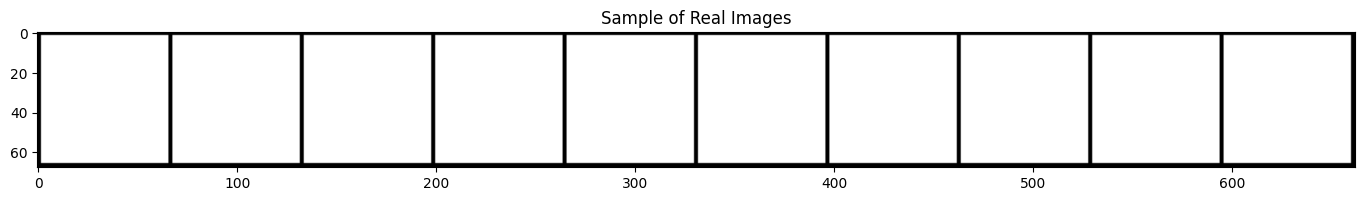

In [87]:
for i in realImagesDataLoader:
    show_batch(i,'Sample of Real Images')
    break

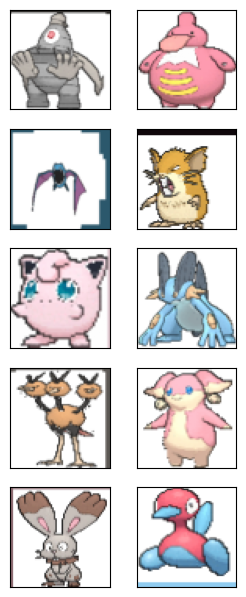

In [88]:
for i in realImagesDataLoader:
    show_images(i, 5, 2, 'title')
    break

## Defining the GAN

Defining Repetitive classes

In [89]:
class ConvLeakyReLU(nn.Module):
    def __init__(self, in_channels, out_channels, alpha, kernel_size=2, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=alpha, inplace=True)
        )

    def forward(self, x):
        return self.conv(x)
    
class ConvReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=2, stride=2):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels,out_channels,kernel_size,stride,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

Defining the Discriminator

In [90]:
class Discriminator(nn.Module):
    
    def __init__(self, alpha):
        super().__init__()

        # input: n_samples x 3 x 64 x 64
        self.conv1 = ConvLeakyReLU(3, 128, alpha)
        self.conv2 = ConvLeakyReLU(128, 256, alpha)
        self.conv3 = ConvLeakyReLU(256,512,alpha)
        self.conv4 = ConvLeakyReLU(512,1024,alpha)
        
        # size : n_samples x 1024 x 4 x 4
        # self.final_conv = nn.Sequential(
        #     nn.Conv2d(1024, 1, 4, 1, padding=0, bias=False),
        #     nn.BatchNorm2d(1),
        #     nn.Sigmoid()
        # )

        self.final_conv = nn.Sequential(
            nn.Conv2d(1024,1,2,2),
            nn.Flatten(),
            nn.Linear(4,1)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.final_conv(x)
        return x

In [91]:
x = torch.randn((10,3,64,64))
model = Discriminator(0.5)
model(x).shape

torch.Size([10, 1])

Defining the Generator

In [92]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        # input: n_samples x 1 x 100
        # self.linear1 = nn.Sequential(
        #     nn.Linear(100,1024*4*4, bias=False),
        #     nn.BatchNorm2d(1024*4*4),
        #     nn.ReLU(inplace=True))
        # shape : n_samples x 1024*4*4 can be reshaped into n_samples x 1024 x 4 x 4

        # transforming input via transpose conv
        # 3 input of size n_samples x 1 x 1 x 1024
        self.conv0 = nn.Sequential(
            nn.ConvTranspose2d(1, 1, 4, 4, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True)
        )
        # shape = n_samples x 1 x 4 x 1024*4
        # can be reshaped as n_samples x 1024 x 4 x 4
        self.conv1 = ConvReLU(1024, 512, 2, 2)
        self.conv2 = ConvReLU(512, 256, 2, 2)
        self.conv3 = ConvReLU(256, 128, 2, 2)
        
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 3, 2, 2, bias=False),
            nn.BatchNorm2d(3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv0(x)
        x = x.reshape((-1,1024, 4, 4))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return x


In [93]:
x = torch.randn((128,1,1,1024))
model = Generator()
disc = Discriminator(0.2)
disc(model(x)).shape

torch.Size([128, 1])

In [94]:
def init_weights(m):
    if type(m) == nn.Conv2d or type(m) == nn.ConvTranspose2d or type(m) == nn.BatchNorm2d or type(m) == nn.Linear:
        nn.init.normal_(m.weight, 0.0, 0.02)

## Training

In [95]:
BATCH_SIZE = 10
LR = 0.0002
NUM_EPOCHS = 20
k = 20
alpha = 0.2
momentum = 0.5
betas = [0.5, 0.999]
# num_batches = len(realImagesDataLoader)//BATCH_SIZE + (len(realImagesDataLoader)%BATCH_SIZE != 0)*1

In [96]:
discriminator = Discriminator(alpha).to(device)
generator = Generator().to(device)
d_optim = torch.optim.Adam(discriminator.parameters(), lr = LR, betas=betas)
g_optim = torch.optim.Adam(generator.parameters(), lr = LR, betas=betas)
loss = nn.BCEWithLogitsLoss(reduction='sum')

In [97]:
discriminator.apply(init_weights)
generator.apply(init_weights)

Generator(
  (conv0): Sequential(
    (0): ConvTranspose2d(1, 1, kernel_size=(4, 4), stride=(4, 4), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv2): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (conv3): ConvReLU(
    (conv): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [98]:
realImagesDataLoader = DataLoader(data, batch_size = BATCH_SIZE, shuffle=True)

In [99]:
num_batches = len(realImagesDataLoader)//BATCH_SIZE + (len(realImagesDataLoader)%BATCH_SIZE != 0)*1

In [100]:
def update_D(X, Z, discriminator, generator, loss, d_optim):
    # updating the discriminator by detaching from Generator
    batch_size = X.shape[0]
    ones = torch.ones(batch_size, device = device).view((batch_size,1))
    zeros = torch.zeros(batch_size, device = device).view((batch_size,1))
    # real images
    pred_real = discriminator(X).view((batch_size,1))
    loss_real = loss(pred_real, ones)
    # fake images
    pred_fake = discriminator(generator(Z).detach()).view((batch_size,-1))
    loss_fake = loss(pred_fake, zeros)
    loss_d = (loss_real + loss_fake)/2
    d_optim.zero_grad()
    loss_d.backward()
    d_optim.step()
    return loss_d.item()

In [101]:
def update_G(Z, discriminator, generator, g_optim, loss, batch_size):
    ones = torch.ones(batch_size, device=device).view((batch_size,1))
    loss_g  = loss(discriminator(generator(Z).detach()).view((batch_size,1)), ones)
    g_optim.zero_grad() 
    loss_g.backward()
    g_optim.step()
    return loss_g.item()

c:\Users\sanje\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch: 1/20, D_loss: 0.0665261558923736, G_loss: 8.814688986456124, time: 79.27956008911133
Epoch: 2/20, D_loss: 0.0003152353042173992, G_loss: 14.457119535494707, time: 65.16799712181091
Epoch: 3/20, D_loss: 6.732968180286894e-05, G_loss: 16.756683045643094, time: 67.2704565525055
Epoch: 4/20, D_loss: 0.0023104697754707496, G_loss: 13.119685893827313, time: 67.65387034416199
Epoch: 5/20, D_loss: 2.3729823602838316e-05, G_loss: 14.473666305287361, time: 69.6953444480896
Epoch: 6/20, D_loss: 7.558596201774836e-06, G_loss: 15.46621639117497, time: 68.83741664886475
Epoch: 7/20, D_loss: 2.7229192745009684e-06, G_loss: 16.20895748114556, time: 69.41955733299255
Epoch: 8/20, D_loss: 1.2423654827144377e-06, G_loss: 16.952352887979718, time: 66.65084338188171
Epoch: 9/20, D_loss: 5.597374754393445e-07, G_loss: 17.70463224094578, time: 69.0138885974884
Epoch: 10/20, D_loss: 3.131640131243524e-07, G_loss: 18.404110121670627, time: 109.864501953125
Epoch: 11/20, D_loss: 1.4005498401744614e-07, G

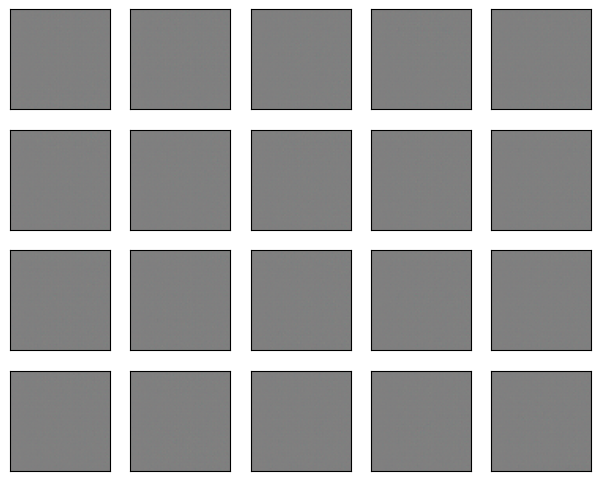

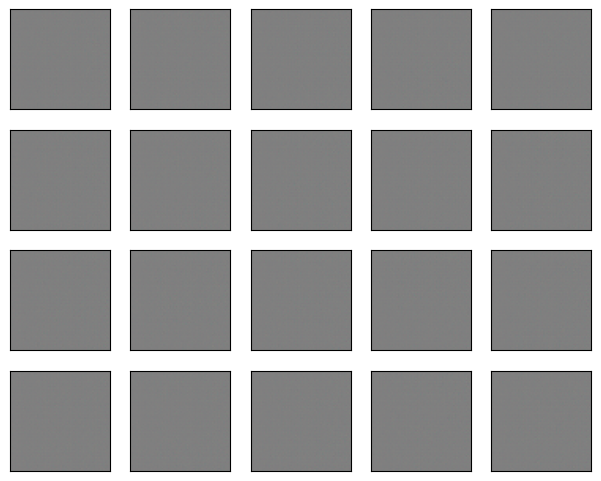

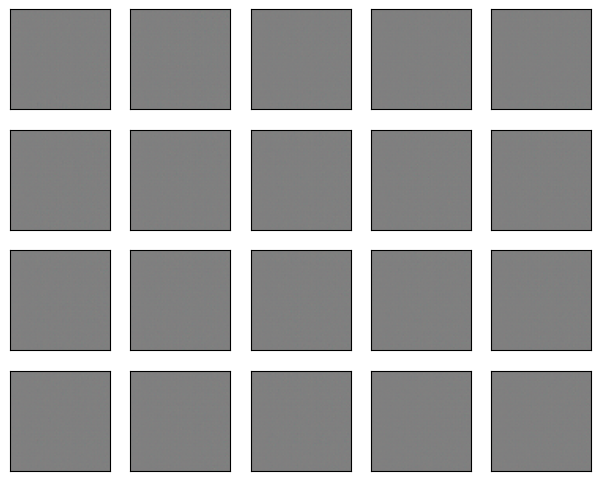

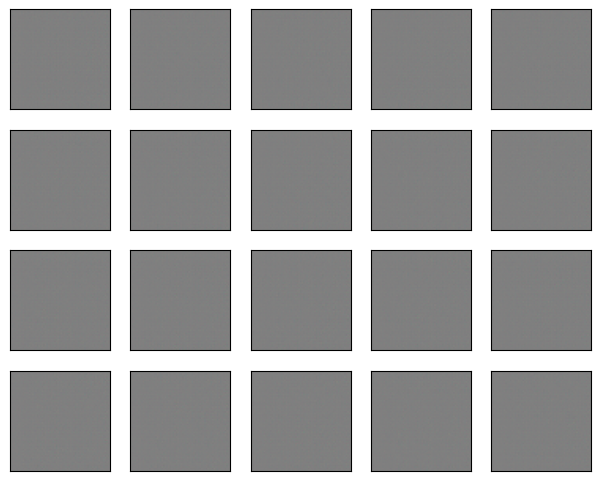

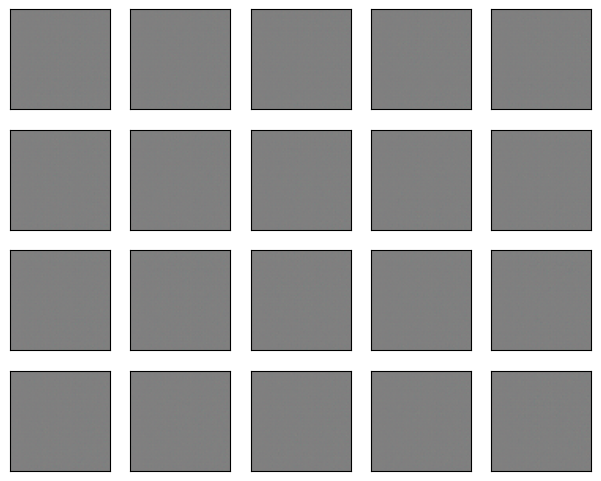

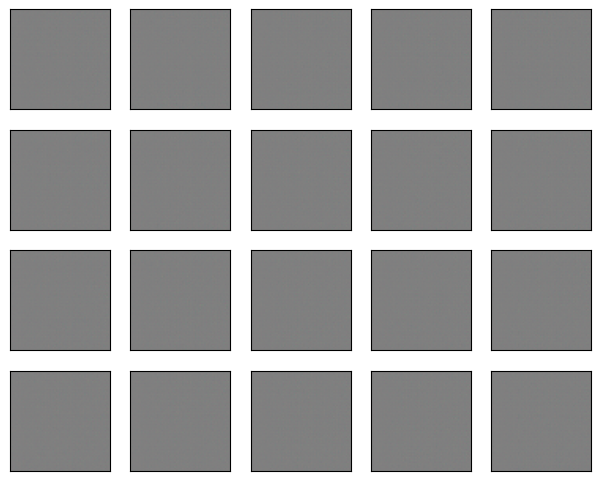

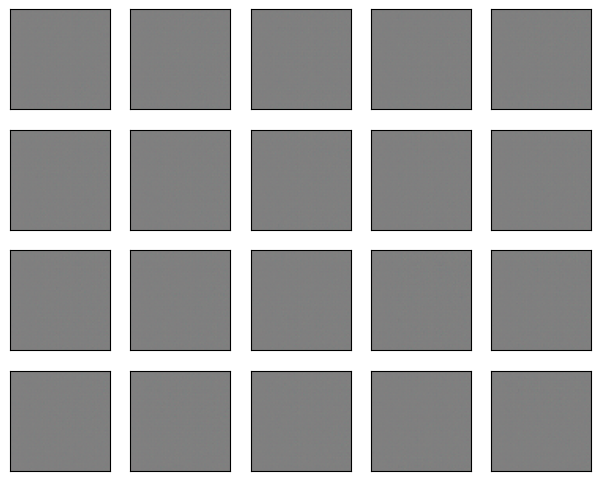

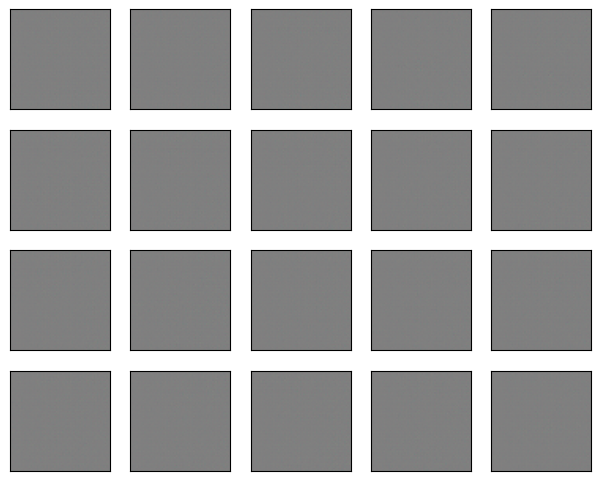

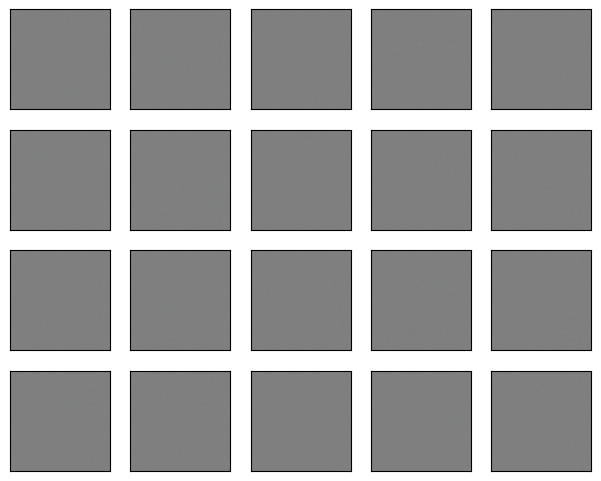

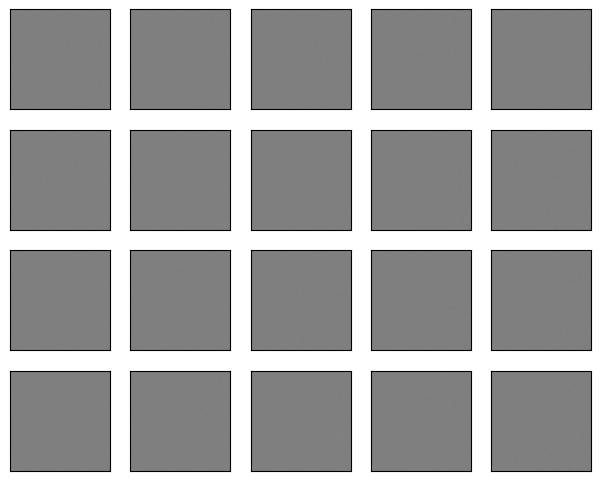

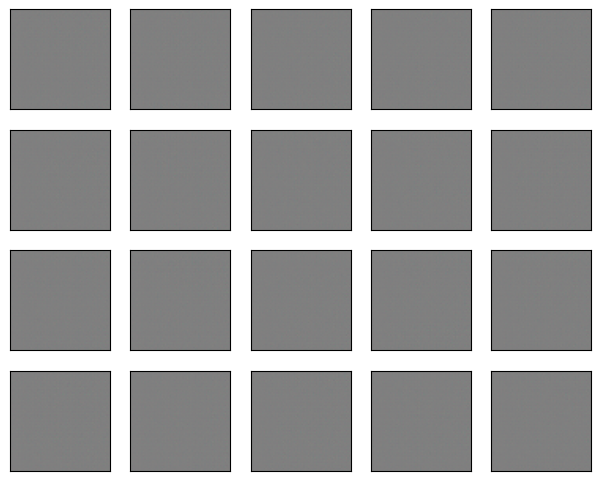

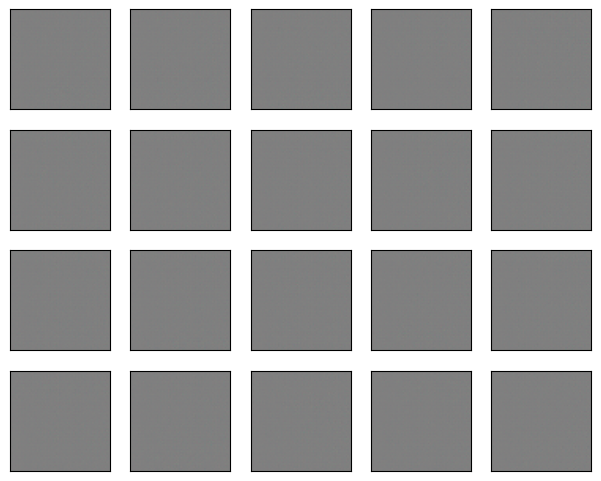

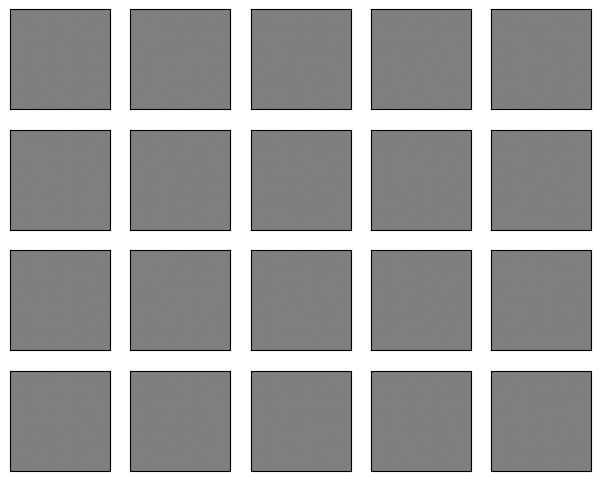

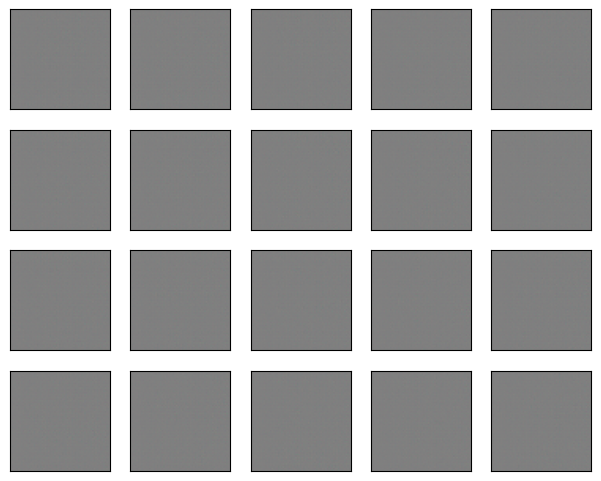

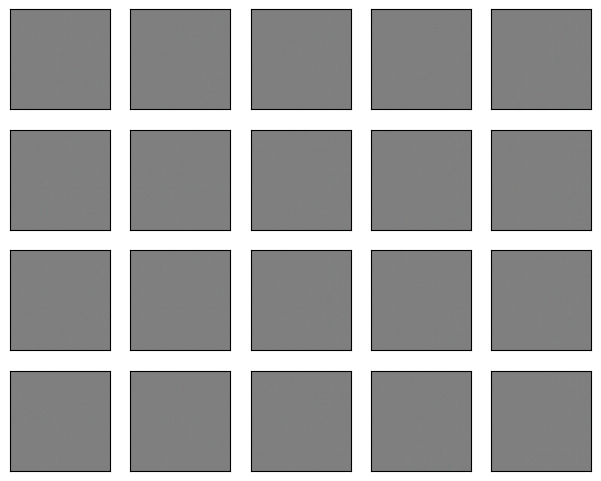

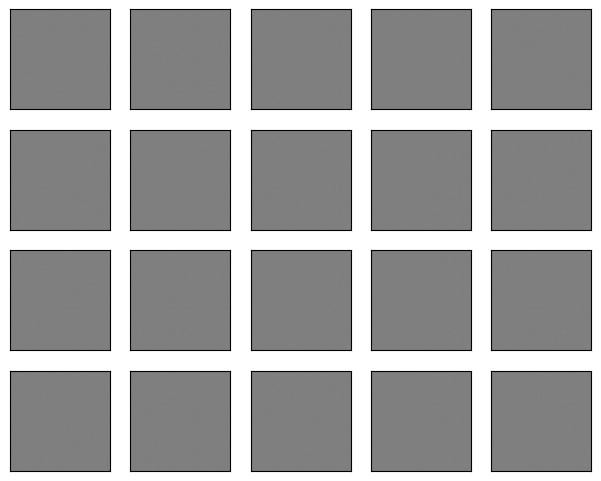

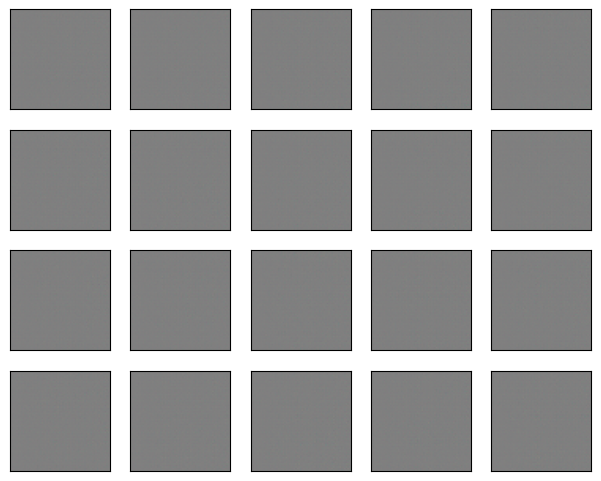

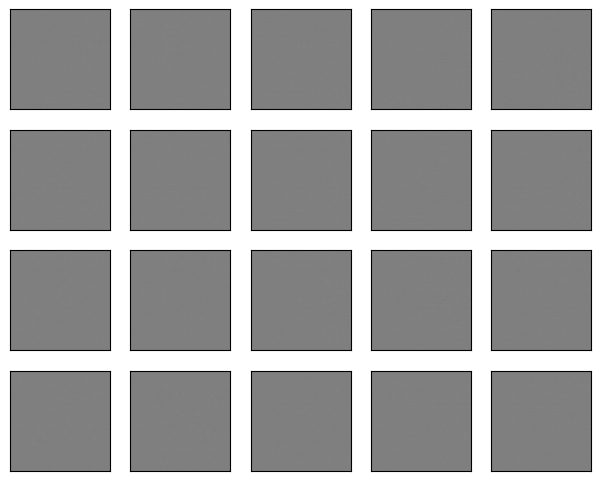

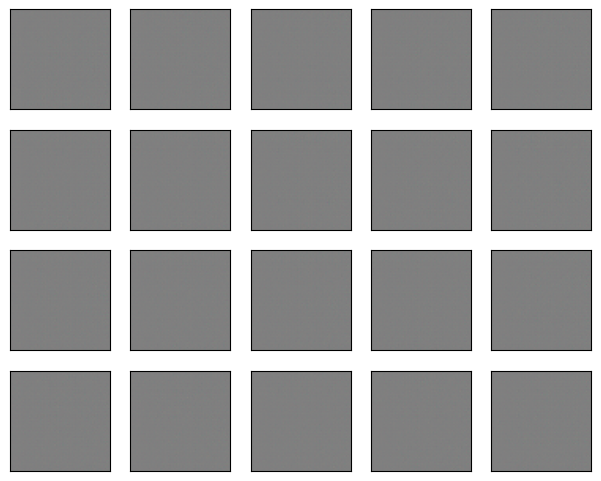

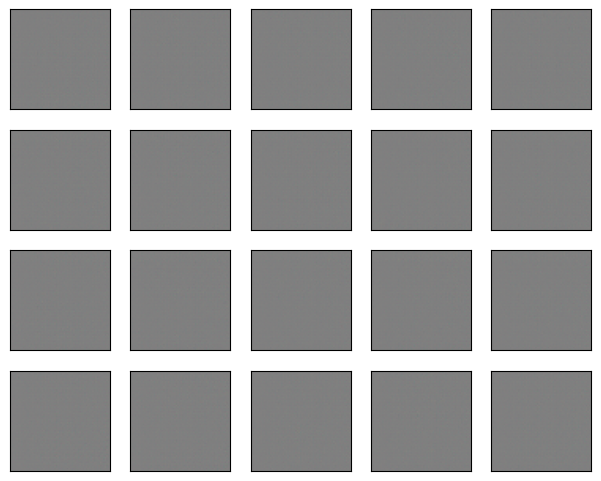

In [102]:
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    running_d_loss, running_g_loss, n = 0.0, 0.0, 0
    for batch in realImagesDataLoader:
        batch_size = batch.shape[0]
        Z = torch.normal(0, 1, (batch_size,1, 1, 1024), device=device)
        running_d_loss += update_D(batch, Z, discriminator, generator, loss, d_optim)
        running_g_loss += update_G(Z, discriminator, generator, g_optim, loss, batch_size)
        n += batch_size
    end_time = time.time()
    print(f"Epoch: {epoch+1}/{NUM_EPOCHS}, D_loss: {running_d_loss/n}, G_loss: {running_g_loss/n}, time: {end_time-start_time}")
    show_images(generator(torch.normal(0,1,(20,1,1,1024),device=device)), 4, 5, 's')

In [108]:
gz = generator(torch.normal(0,1,(20,1,1,1024),device=device))
print(torch.min(gz))

tensor(-0.0778, device='cuda:0', grad_fn=<MinBackward1>)


In [109]:
def show_images(images, num_rows, num_cols, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    for i in range(num_rows):
        for j in range(num_cols):
            axes[i, j].imshow(images[i * num_cols + j])
            axes[i, j].axes.get_xaxis().set_visible(False)
            axes[i, j].axes.get_yaxis().set_visible(False)
    return axes

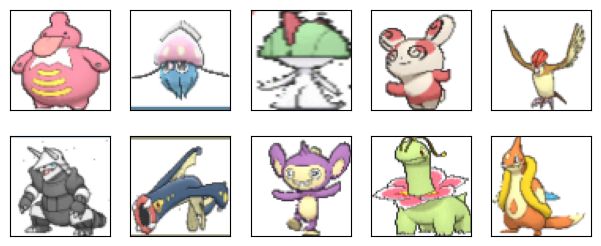

In [112]:
import warnings
warnings.filterwarnings('ignore')
for X in realImagesDataLoader:
    imgs = X[:10].cpu().permute(0, 2, 3, 1) / 2 + 0.5
    show_images(imgs, 2, 5)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [119.46623..133.75851].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [120.042946..132.9888].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [119.75018..132.83446].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [121.259315..133.96884].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [120.79087..133.7229].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [120.46811..133.27185].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [120.55511..132.

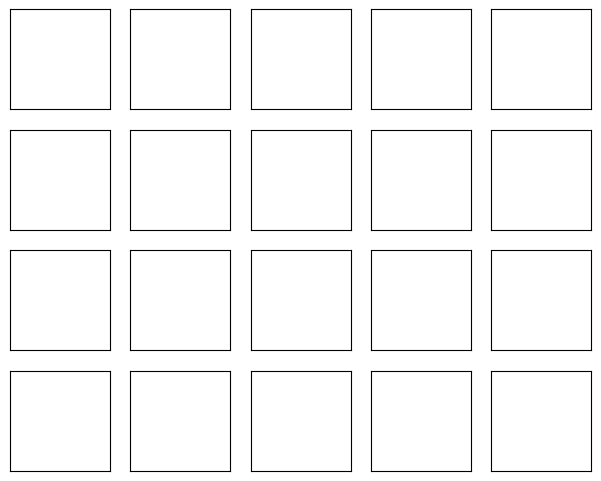

In [122]:
warnings.filterwarnings('ignore')
gz = generator(torch.normal(0,1,(20,1,1,1024), device=device)).to('cpu').detach().permute(0,2,3,1)*127.5 + 127.5
# print(torch.min(gz))
show_images(gz, 4, 5);

In [103]:
def train():
    d_losses = []
    g_losses = []
    # initialising
    for w in discriminator.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in generator.parameters():
        nn.init.normal_(w, 0, 0.02)
    
    for epoch in range(NUM_EPOCHS):
        running_d_loss = 0
        running_g_loss = 0
        
        for X in realImagesDataLoader:
            # training discriminator
            generator.train(False)
            discriminator.train(True)
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, 1, 1, 1024)).to(device)
            G_of_z = generator(Z)
            pred_fake = discriminator(G_of_z)
            y_fake = torch.zeros((batch_size, 1)).to(device)
            loss_fake = loss(pred_fake, y_fake)
            pred_real = discriminator(X)
            y_real = torch.ones((batch_size, 1)).to(device)
            loss_real = loss(pred_real,y_real)
            loss_d = loss_real + loss_fake
            running_d_loss += loss_d
            d_optim.zero_grad()
            loss_d.backward()
            d_optim.step()

            # training generator
            generator.train(True)
            discriminator.train(False)
            z = torch.normal(0, 1, (batch_size, 1, 1, 1024)).to(device)
            G_of_z = generator(z)
            pred_fake = discriminator(G_of_z)
            y_fake = torch.ones((batch_size, 1)).to(device)
            loss_g = loss(pred_fake, y_fake)
            running_g_loss += loss_g
            g_optim.zero_grad()
            loss_g.backward()
            g_optim.step()

        d_losses.append(running_d_loss/num_batches)
        g_losses.append(running_g_loss/num_batches)
        print(f'epoch = {epoch}, d_loss = {running_d_loss/num_batches}, g_loss = {running_g_loss/num_batches}')
        show_batch(generator(torch.normal(0,1,(batch_size,1,1,1024))), f'Epoch {epoch+1}/{NUM_EPOCHS}')

            


In [104]:
# warnings.filterwarnings("ignore")
# d_losses = []
# g_losses = []
# for epoch in range(NUM_EPOCHS):
#     d_running_loss = 0
#     g_loss = 0
#     for i in range(k):
#         # training the discriminator
#         generator.train(False)
#         discriminator.train(True)
#         for batch in realImagesDataLoader:
#             if batch.shape[0] != BATCH_SIZE:
#                 break
#             d_optim.zero_grad()
#             # sampling [BATCH_SIZE] noise samples of shape 1 x 1 x 1024
#             z = torch.randn((BATCH_SIZE, 1, 1, 1024)).to(device)
#             G_of_z = generator(z)

#             # finding the loss of discriminating fake images
#             pred_fake = discriminator(G_of_z)
#             y_fake = torch.zeros((BATCH_SIZE, 1)).to(device)
#             loss_fake = F.binary_cross_entropy(pred_fake, y_fake)
            
#             # finding the loss of discriminating real images
#             # print(f'batch.shape = {batch.shape}')
#             pred_real = discriminator(batch)
#             y_real = torch.ones((BATCH_SIZE, 1)).to(device)
#             # print(pred_real.shape, y_real.shape)
#             loss_real = F.binary_cross_entropy(pred_real, y_real)

#             # training on complete loss
#             d_loss = loss_fake + loss_real
#             d_running_loss += d_loss
#             d_loss.backward()
#             d_optim.step()
#             # break
#     d_losses.append(d_running_loss/k)
#     # training the generator
#     generator.train(True)
#     discriminator.train(False)
#     for batch in realImagesDataLoader:
#         if batch.shape[0] != BATCH_SIZE:
#             break
#         g_optim.zero_grad()
#         z = torch.randn((BATCH_SIZE, 1, 1, 1024)).to(device)
#         G_of_z = generator(z)
#         pred_fake = discriminator(G_of_z)
#         y_fake = torch.ones((BATCH_SIZE, 1)).to(device)
#         g_loss = F.binary_cross_entropy(pred_fake, y_fake)
#         g_loss.backward()
#         g_optim.step()
#         # break
#     g_losses.append(g_loss)
#     print(f'Epoch {epoch+1}/{NUM_EPOCHS} | d_loss: {d_losses[-1]} | g_loss: {g_losses[-1]}')
#     show_batch(G_of_z, f'Epoch {epoch+1}')
        